In [44]:
import scanpy as sc
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import anndata as ad
import torch
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using device: {device}")
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [4, 4]

True
using device: cuda


In [45]:
from mcg_ae_mae import AE, compute_loss, train_step

In [46]:
# read in original data and base imputation methods data
adata = sc.read_h5ad("mcg_210505_5618x670.h5ad")
zdata = sc.read_h5ad("mcg_210505_5618x670_zero_imputation.h5ad")
mdata = sc.read_h5ad("mcg_210505_5618x670_mean_imputation.h5ad")
kdata = sc.read_h5ad("mcg_210505_5618x670_knn_imputation.h5ad")

In [47]:
# get mask to impute values with coverage <5
mask = pd.read_parquet("mask.parquet")
mask.head(2)

geneslop2k,PRKCZ,ENSG00000157933.11,PRDM16,ENSG00000162591.17,ENSG00000171735.20,ENSG00000142599.20,CASZ1,KAZN,IGSF21,EPHB2,...,EFCAB6,PARVB,PRR5-ARHGAP8,PHF21B,CELSR1,GRAMD4,TBC1D22A,ENSG00000224271.8,TAFA5,ENSG00000188511.14
20210505-UMB5577-preAb-PFC-A09-L1_A1,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
20210505-UMB5577-preAb-PFC-A09-L1_A10,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


In [48]:
# get random dropout mask for evaluation metrics
dropout_mask = pd.read_parquet("dropout_mask.parquet")
dropout_mask.head(2)

geneslop2k,PRKCZ,ENSG00000157933.11,PRDM16,ENSG00000162591.17,ENSG00000171735.20,ENSG00000142599.20,CASZ1,KAZN,IGSF21,EPHB2,...,EFCAB6,PARVB,PRR5-ARHGAP8,PHF21B,CELSR1,GRAMD4,TBC1D22A,ENSG00000224271.8,TAFA5,ENSG00000188511.14
20210505-UMB5577-preAb-PFC-A09-L1_A1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
20210505-UMB5577-preAb-PFC-A09-L1_A10,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [49]:
# set xdata to the base imputation method data to push through autoencoder
xdata = mdata

In [50]:
# set X as data
X = xdata.to_df().astype("float32")

# convert to tensors so readable to computer during training
X = torch.tensor(X.values).to(device)

X.shape, X.shape[1]

(torch.Size([5618, 670]), 670)

## check that everything went in properly

In [51]:
# create dataframe
methyl_df = xdata.to_df()
# check for na's
methyl_df.isna().sum().sum() # should be 0

np.int64(0)

In [52]:
# check that coverage mask is correct
methyl_df = methyl_df[mask]
methyl_df.isna().sum().sum() # should be 102112

np.int64(102112)

In [53]:
# check that dropout mask is correct
methyl_df = methyl_df[~dropout_mask]
methyl_df.isna().sum().sum() # should be 285017

np.int64(285017)

In [54]:
# check that range of data is [-1, 1]
xdata.to_df().min().min(), xdata.to_df().max().max()

(-1.0, 1.0)

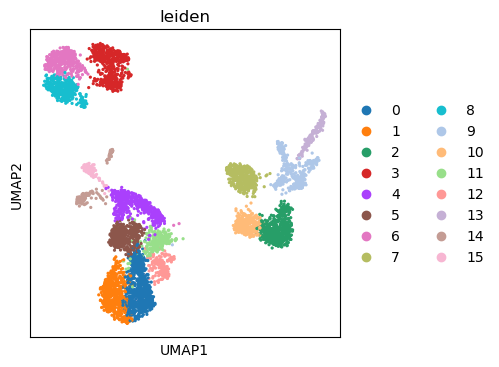

In [55]:
# visualize leiden clusters on umap
sc.pl.umap(xdata, color="leiden")

## Train Model

In [56]:
# initialize model & optimizer
model = AE(input_dim=X.shape[1], hidden_dim=64, latent_dim=32).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [57]:
# load data into batches
from torch.utils.data import Dataset, DataLoader

class AutoencoderDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index].to(device)
    
dataset = AutoencoderDataset(X)
dataloader = DataLoader(dataset=dataset, batch_size=128, shuffle=True)

In [58]:
%%time

# training loop
epochs = 1000
loss_hist = [] # initialize empty loss history list
no_improve_counter = 0 # initialize no improvement counter at 0
patience = 20
min_decrease = 0.000001
best_loss = float("inf") # initialize best loss at infinity

for epoch in range(epochs):
    epoch_loss = 0.0 # initialize epoch loss accumulator at 0
 
    for data in dataloader:
        loss = train_step(model, data, optimizer)
        epoch_loss += loss
        
    avg_epoch_loss = epoch_loss / len(dataloader)
    loss_hist.append(avg_epoch_loss)
    
    if avg_epoch_loss < best_loss - min_decrease:
        best_loss = avg_epoch_loss
        no_improve_counter = 0
    else:
        no_improve_counter += 1
        
    if no_improve_counter >= patience:
        print(f"early stopping at epoch {epoch + 1}, avg loss: {avg_epoch_loss:.6f}")
        break
        
    if epoch % 100 == 0:
        print(f"epoch {epoch + 1}, avg loss: {avg_epoch_loss:.6f}")

epoch 1, avg loss: 0.323623
epoch 101, avg loss: 0.067340
epoch 201, avg loss: 0.066936
epoch 301, avg loss: 0.066501
epoch 401, avg loss: 0.066275
early stopping at epoch 420, avg loss: 0.066195
CPU times: user 1min 14s, sys: 889 ms, total: 1min 15s
Wall time: 1min 15s


## Generate Data

In [59]:
ae_imp = pd.DataFrame(model.inference(X.to(device)).detach().cpu().numpy(), index=adata.to_df().index, columns=adata.to_df().columns)
ae_imp.head(2)

geneslop2k,PRKCZ,ENSG00000157933.11,PRDM16,ENSG00000162591.17,ENSG00000171735.20,ENSG00000142599.20,CASZ1,KAZN,IGSF21,EPHB2,...,EFCAB6,PARVB,PRR5-ARHGAP8,PHF21B,CELSR1,GRAMD4,TBC1D22A,ENSG00000224271.8,TAFA5,ENSG00000188511.14
20210505-UMB5577-preAb-PFC-A09-L1_A1,0.593447,0.556719,0.603182,0.609545,0.578344,0.593771,0.591067,0.565609,0.615925,0.603017,...,0.577524,0.595695,0.593444,0.585473,0.604746,0.621307,0.586287,0.600496,0.591676,0.603519
20210505-UMB5577-preAb-PFC-A09-L1_A10,0.503249,0.532741,0.561767,0.573179,0.553047,0.535607,0.545615,0.562614,0.519063,0.549822,...,0.530745,0.544580,0.572236,0.577390,0.555481,0.527763,0.558736,0.547679,0.548643,0.543211


In [60]:
ae_imp.isna().sum().sum(), ae_imp.shape, ae_imp.min().min(), ae_imp.max().max()

(np.int64(0), (5618, 670), -0.10116617381572723, 0.738455057144165)

## Evaluation Metrics

In [61]:
from evaluation import mae_per_feat, mae_per_feat_masked

In [62]:
mae = mae_per_feat(xdata.to_df(), ae_imp)
mae_true = mae_per_feat_masked(xdata.to_df(), ae_imp, mask)
mae_true_rand = mae_per_feat_masked(xdata.to_df(), ae_imp, dropout_mask)

In [63]:
mae.mean(), mae_true.mean(), mae_true_rand.mean()

(np.float64(0.0662289195611812),
 np.float64(0.06588502037009474),
 np.float64(0.001304873556927525))

<Axes: >

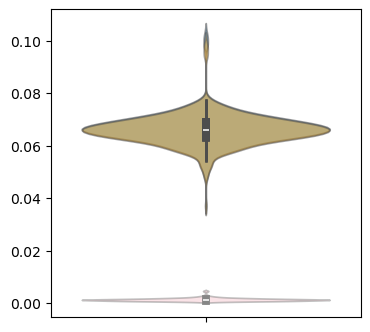

In [64]:
sns.violinplot(mae, alpha=0.5)
sns.violinplot(mae_true, alpha=0.5, color="orange")
sns.violinplot(mae_true_rand, alpha=0.5, color="pink")

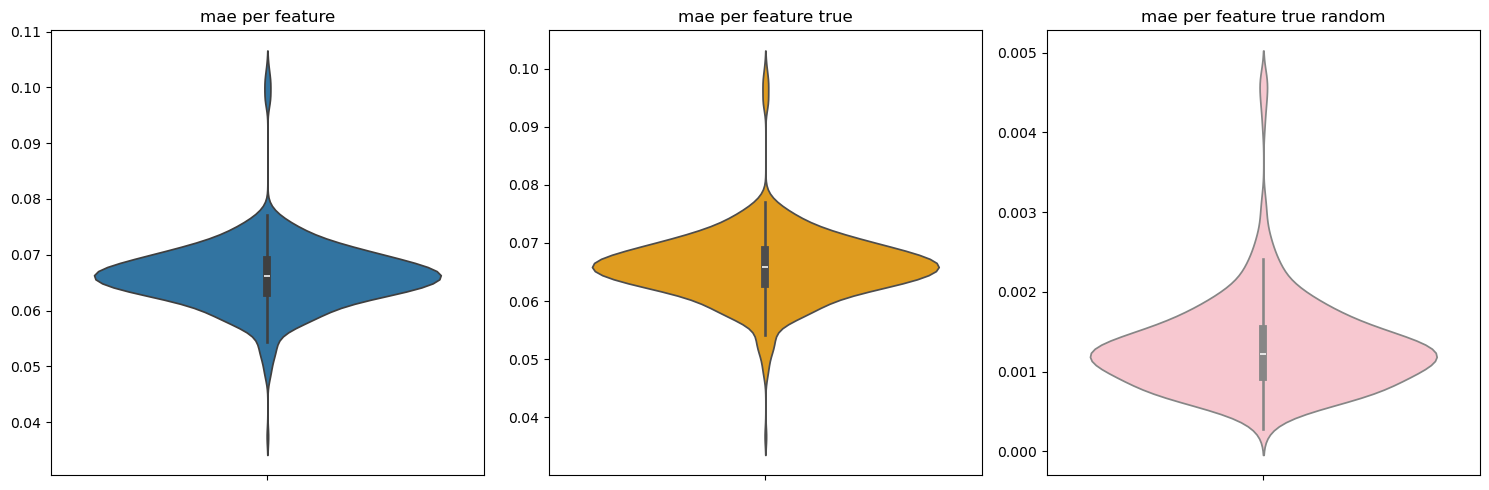

In [65]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.violinplot(mae, ax=axes[0])
axes[0].set_title("mae per feature")

sns.violinplot(mae_true, ax=axes[1], color="orange")
axes[1].set_title("mae per feature true")

sns.violinplot(mae_true_rand, color="pink")
axes[2].set_title("mae per feature true random")

plt.tight_layout()
plt.show()

In [66]:
# create AnnData object of autoencoder data
aedata = ad.AnnData(X=ae_imp)
aedata.obs = adata.obs.copy()
aedata.var = adata.var.copy()

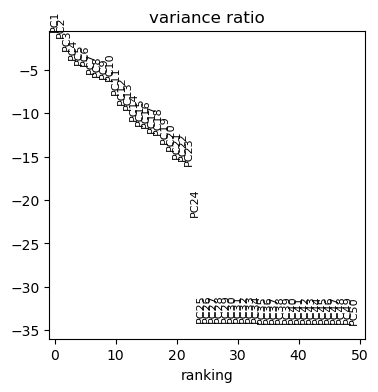

In [67]:
# pca
sc.tl.pca(aedata)
sc.pl.pca_variance_ratio(aedata, n_pcs=50, log=True)

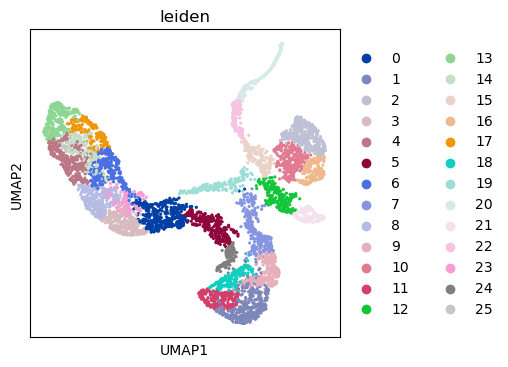

In [68]:
# umap
sc.pp.neighbors(aedata)
sc.tl.leiden(aedata)
sc.tl.umap(aedata)
sc.pl.umap(aedata, color="leiden")

In [69]:
xdata.obs["source"] = "base imputation"
aedata.obs["source"] = "autoencoder"

In [70]:
cdata = xdata.concatenate(aedata, batch_key=None)
cdata.shape, 5618*2

((11236, 670), 11236)

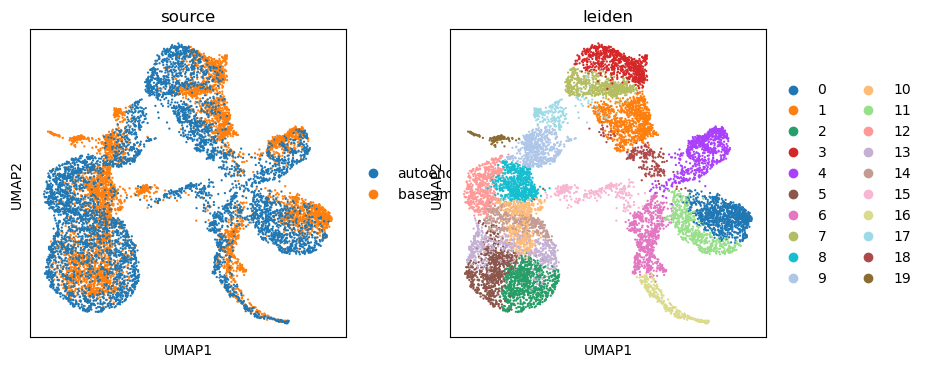

In [71]:
sc.tl.pca(cdata)
sc.pp.neighbors(cdata)
sc.tl.leiden(cdata)
sc.tl.umap(cdata)
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(cdata, color=["source", "leiden"])

2025-10-20 00:16:59,379 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-10-20 00:17:02,149 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-10-20 00:17:02,282 - harmonypy - INFO - Iteration 1 of 20
2025-10-20 00:17:05,719 - harmonypy - INFO - Iteration 2 of 20
2025-10-20 00:17:09,061 - harmonypy - INFO - Iteration 3 of 20
2025-10-20 00:17:12,414 - harmonypy - INFO - Iteration 4 of 20
2025-10-20 00:17:15,771 - harmonypy - INFO - Converged after 4 iterations


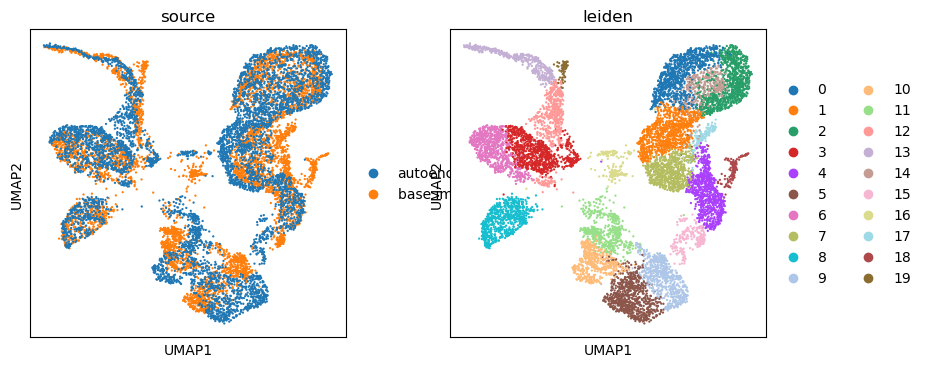

In [72]:
sc.external.pp.harmony_integrate(cdata, "source", max_iter_harmony=20)
sc.pp.neighbors(cdata, n_pcs=20, n_neighbors=20, use_rep="X_pca_harmony")
sc.tl.leiden(cdata)
sc.tl.umap(cdata)
sc.pl.umap(cdata, color=["source", "leiden"])

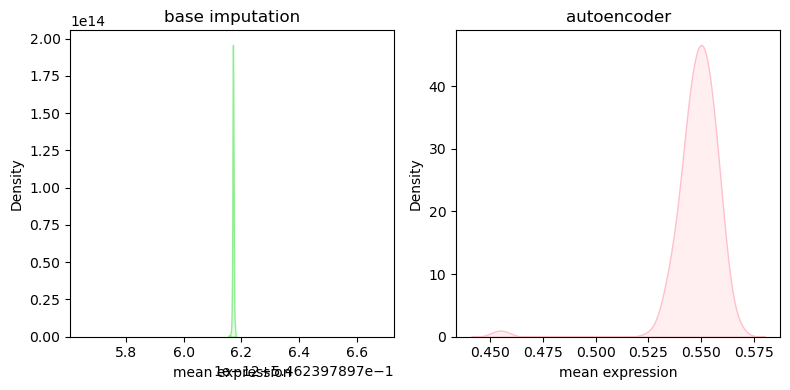

In [73]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
sns.kdeplot(x=xdata.to_df().mean(), ax=axes[0], fill=True, color="lightgreen",)
axes[0].set_title("base imputation")
axes[0].set_xlabel("mean expression")

sns.kdeplot(x=aedata.to_df().mean(), ax=axes[1], fill=True, color="pink")
axes[1].set_title("autoencoder")
axes[1].set_xlabel("mean expression")
plt.tight_layout()

In [74]:
# combine the means into one DataFrame
combined = pd.concat([
    pd.DataFrame({"means": xdata.to_df().mean(), "source": "base imputation"}),
    pd.DataFrame({"means": aedata.to_df().mean(), "source": "autoencoder"})
])

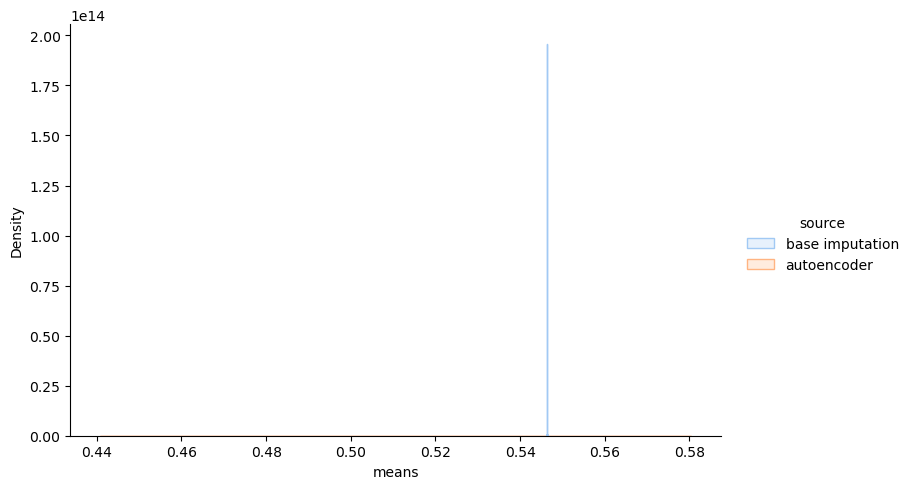

In [75]:
# plot overlapping KDEs
sns.displot(data=combined, x="means", hue="source", kind="kde", fill=True, palette="pastel", aspect=1.5, height=5, common_norm=False)

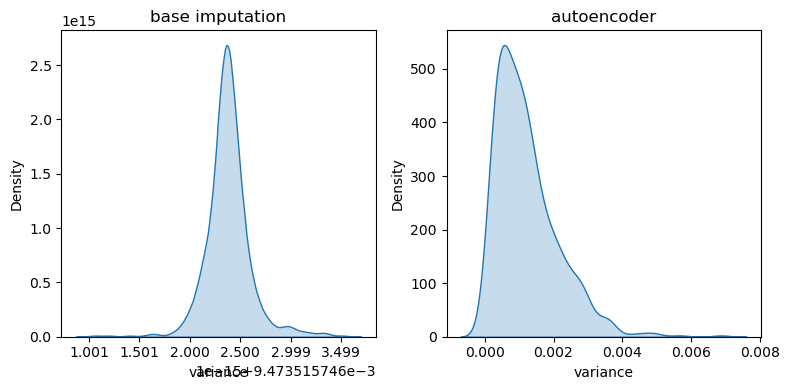

In [76]:
# plot distribution of feature variances
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

feat_var = xdata.to_df().var()
sns.kdeplot(feat_var, ax=axes[0], fill=True)
axes[0].set_title("base imputation")
axes[0].set_xlabel("variance")

feat_var = aedata.to_df().var()
sns.kdeplot(feat_var, ax=axes[1], fill=True)
axes[1].set_title("autoencoder")
axes[1].set_xlabel("variance")

plt.tight_layout()

In [77]:
sc.tl.rank_genes_groups(cdata, groupby="source")
top_genes = cdata.uns["rank_genes_groups"]["names"]["base imputation"][:20]
top_genes

array(['PCDHGA1', 'PCDHGA2', 'PCDHGA3', 'PCDHGB1', 'PCDHGB2', 'PCDHGA5',
       'PCDHGA4', 'CUX2', 'ABR', 'RBFOX3', 'TMEM132B', 'ENSG00000282278',
       'RBFOX1', 'ENSG00000196498.14', 'MARK4', 'NTRK3', 'GRIN2A',
       'MYT1L', 'CSMD1', 'ADGRB1'], dtype=object)

base imputation


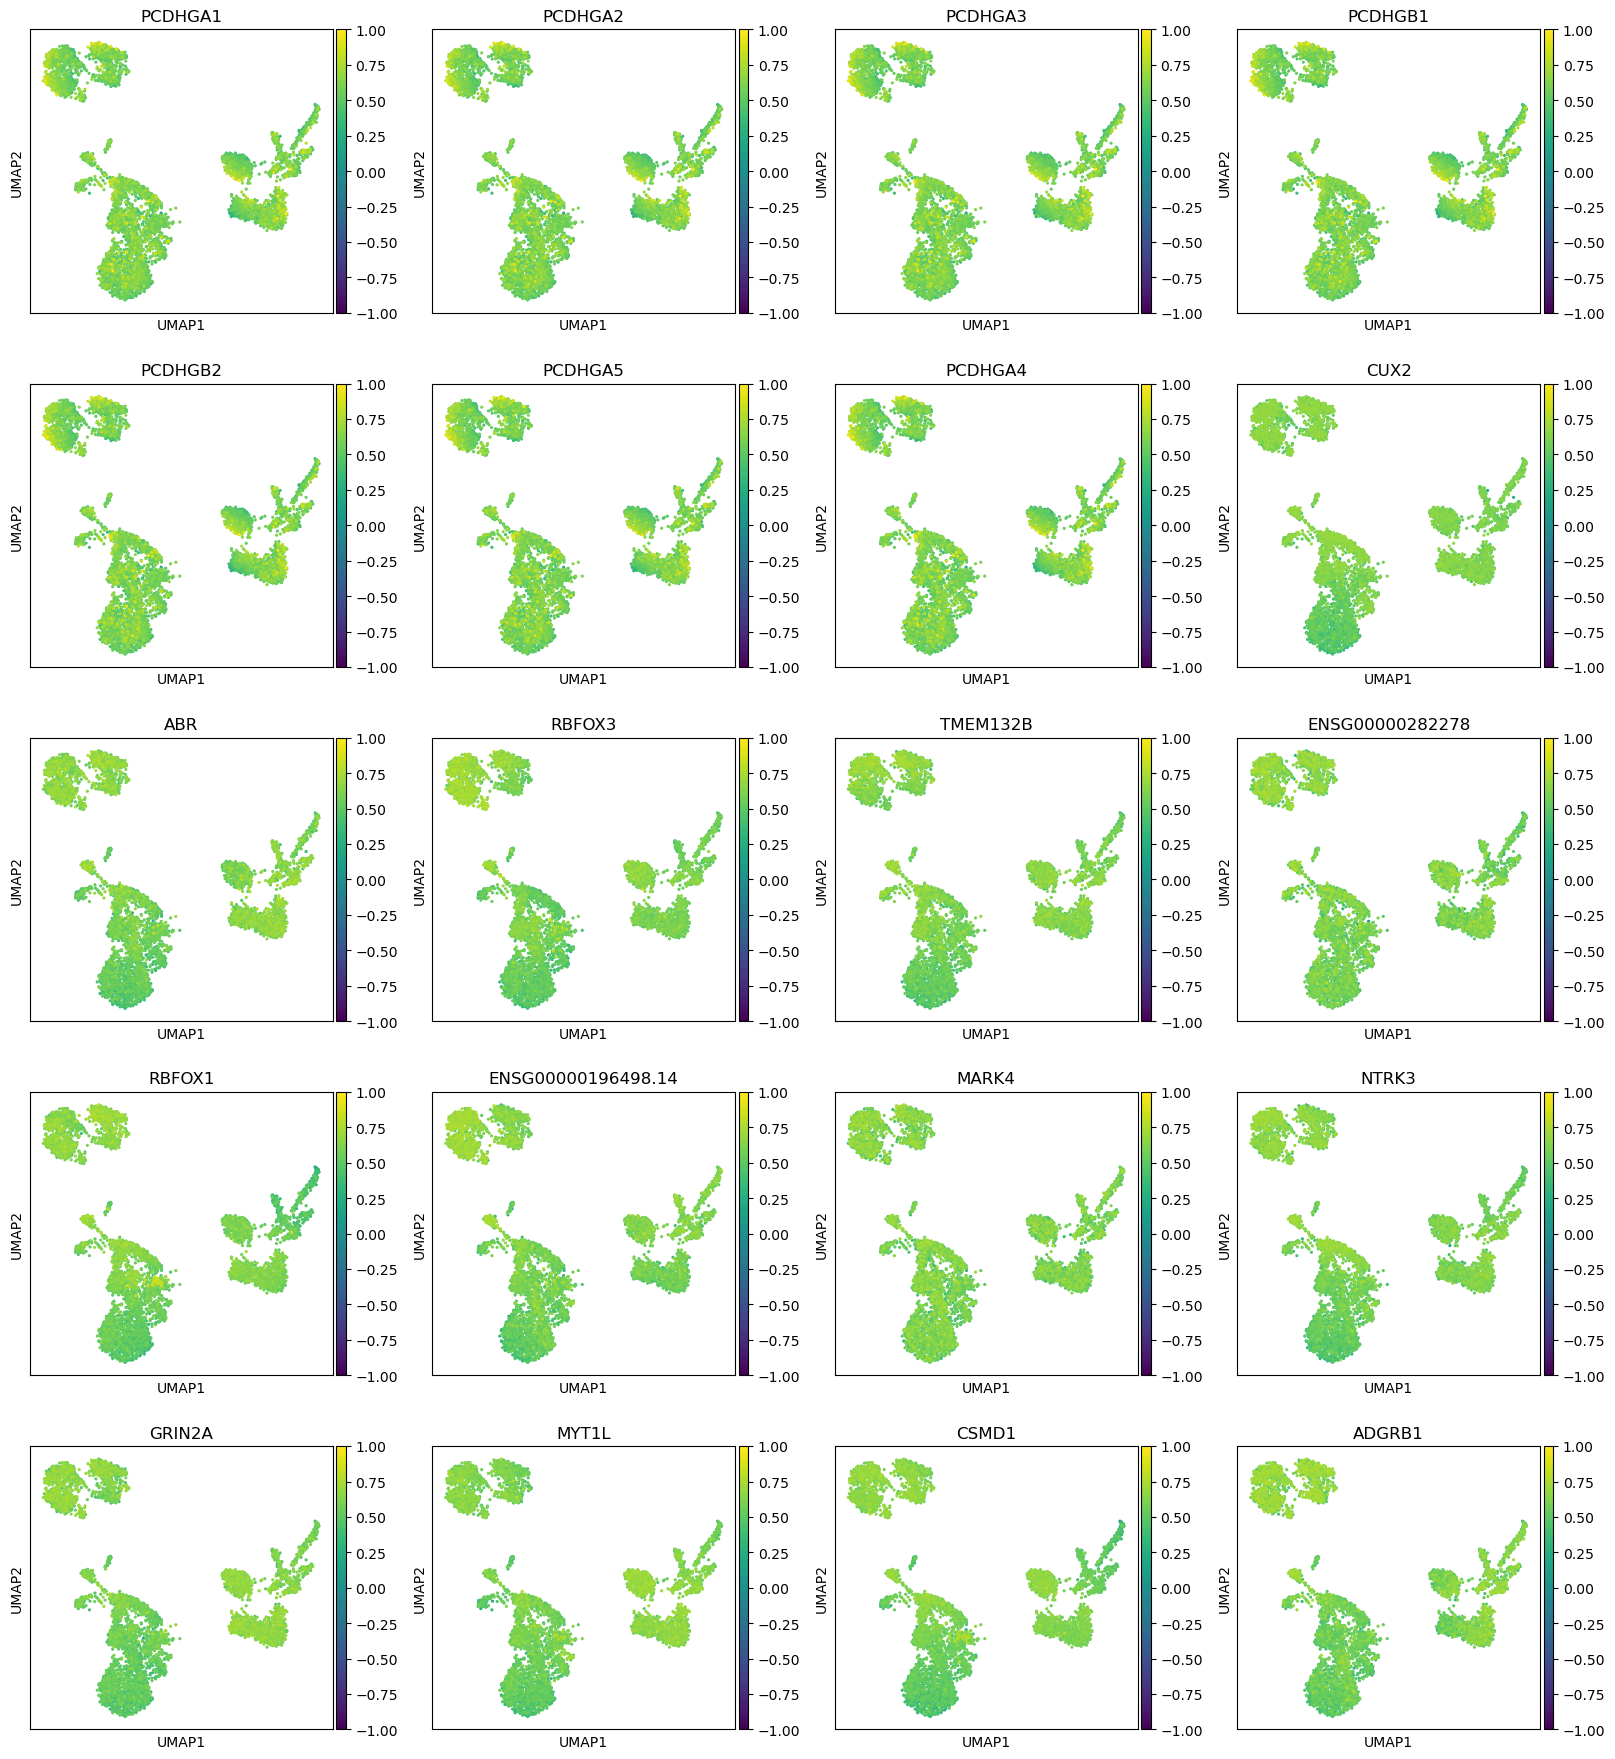

In [78]:
print("base imputation")
sc.pl.umap(xdata, color=top_genes, ncols=4, vmin=-1, vmax=1)

In [79]:
sc.tl.rank_genes_groups(cdata, groupby="source")
top_genes = cdata.uns["rank_genes_groups"]["names"]["autoencoder"][:20]
top_genes

array(['HLCS', 'LRP5', 'ENSG00000182648.15', 'ENSG00000162591.17', 'ERC1',
       'PIEZO2', 'BACH1', 'ENSG00000160299.19', 'ENSG00000176406.25',
       'ENSG00000129116.20', 'FAM189A1', 'ADAMTS17', 'SHISA6', 'GLI3',
       'ERICH1', 'GPHN', 'ENSG00000152818.20', 'IGF1R', 'ROBO1', 'GLIS1'],
      dtype=object)

autoencoder


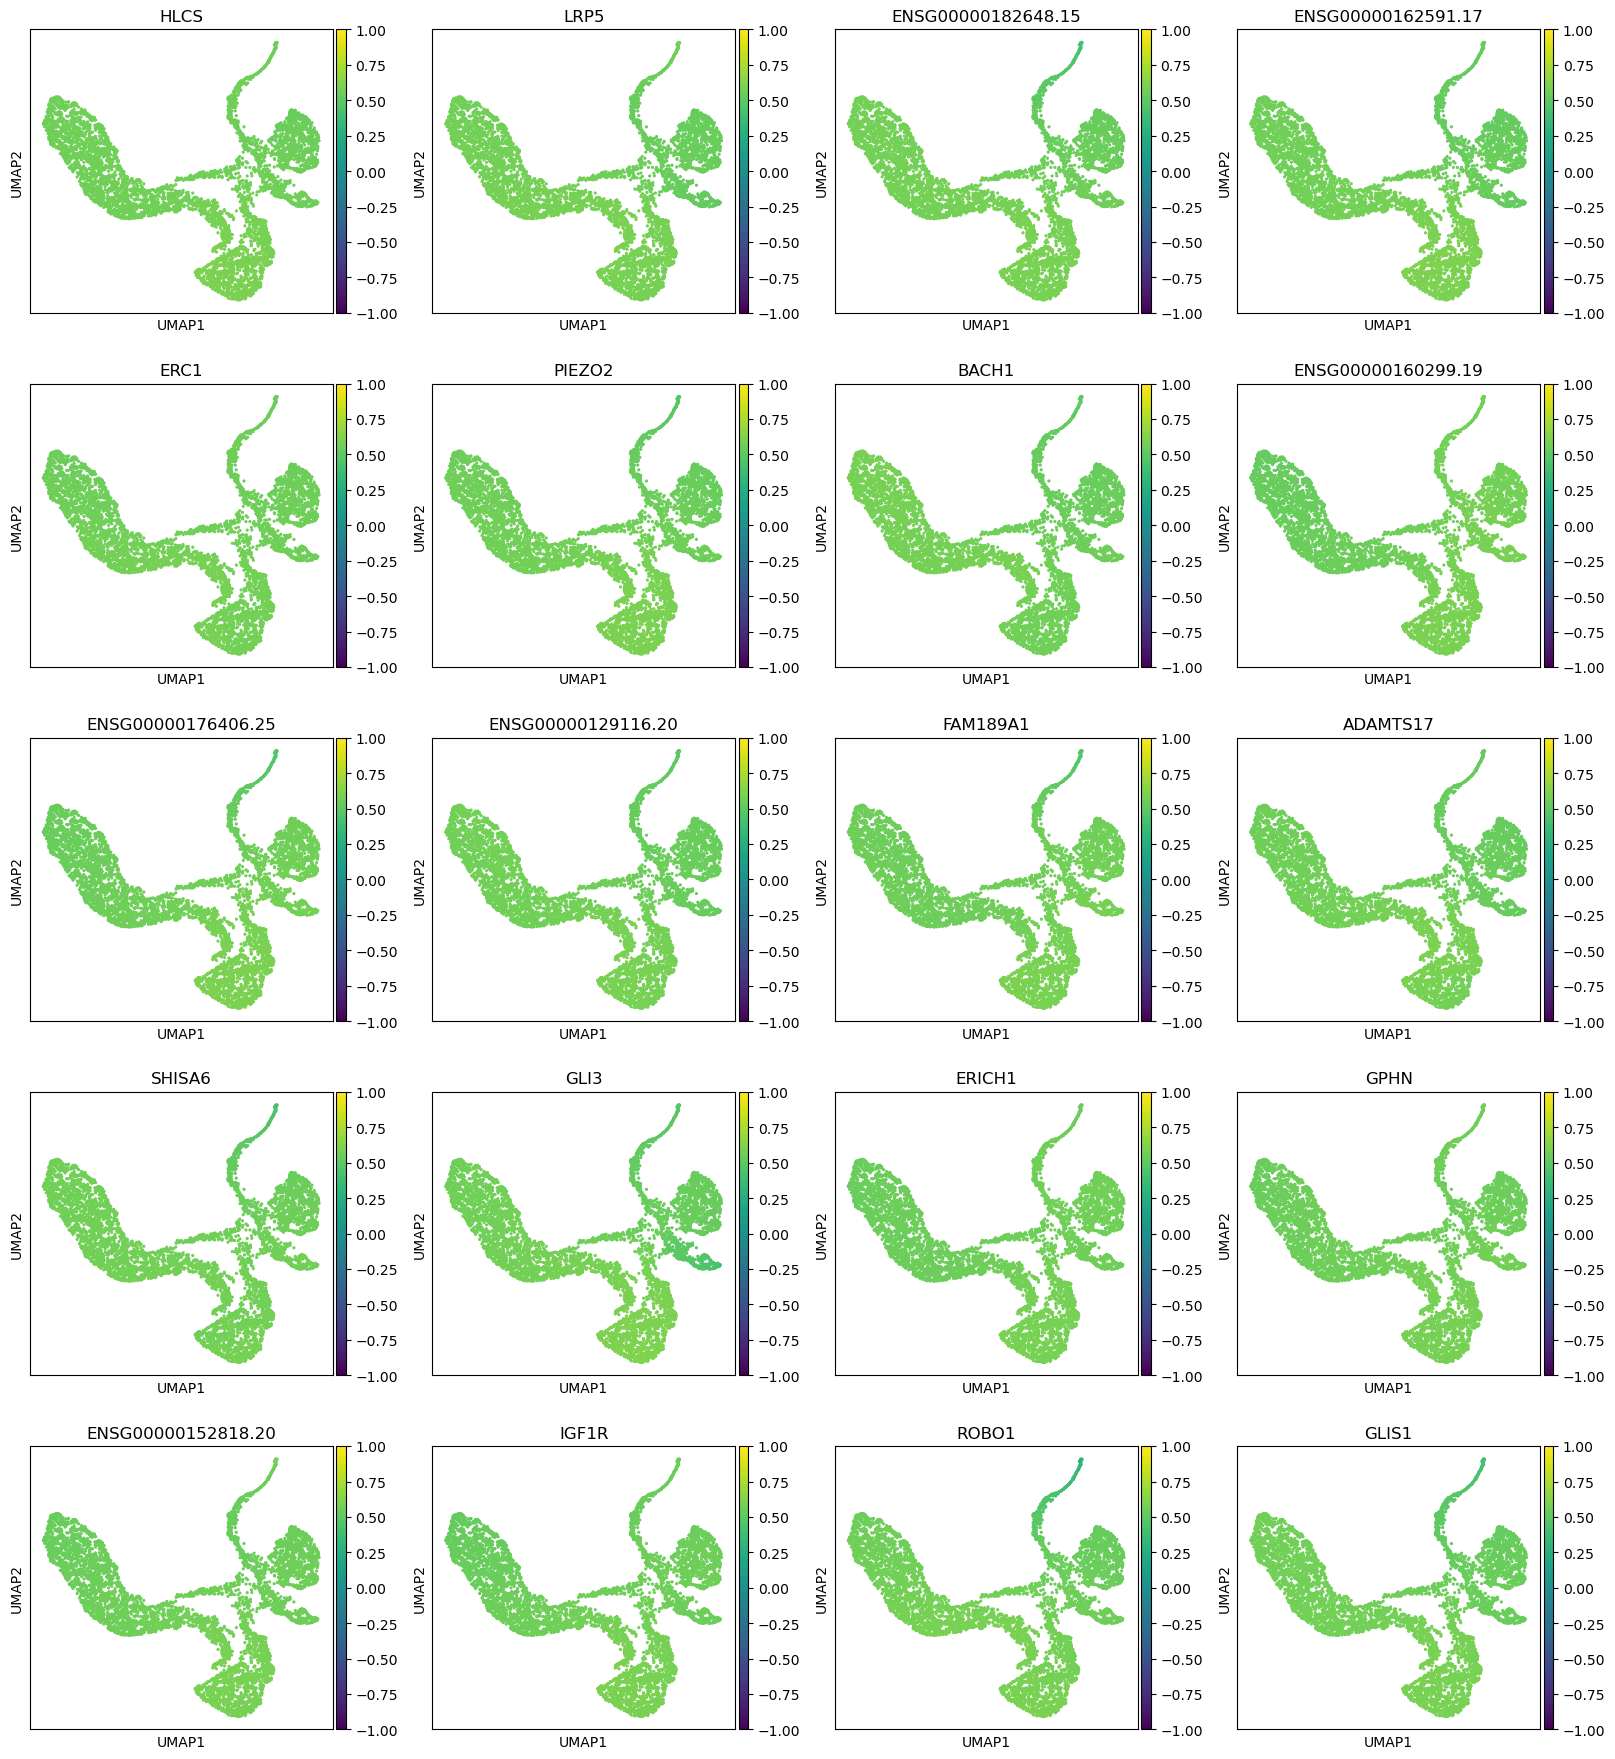

In [80]:
print("autoencoder")
sc.pl.umap(aedata, color=top_genes, ncols=4, vmin=-1, vmax=1)

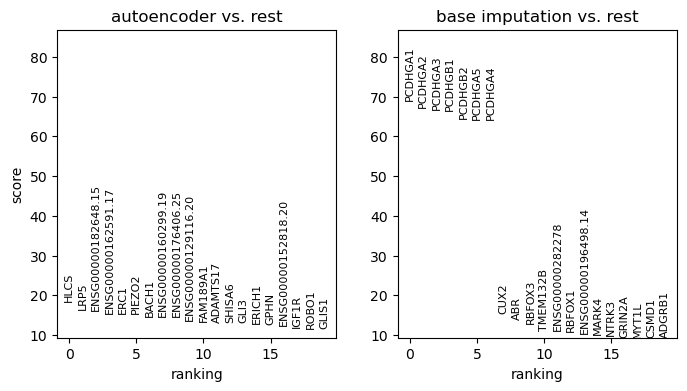

In [81]:
# top 20 gene expressions
sc.pl.rank_genes_groups(cdata, n_genes=20)

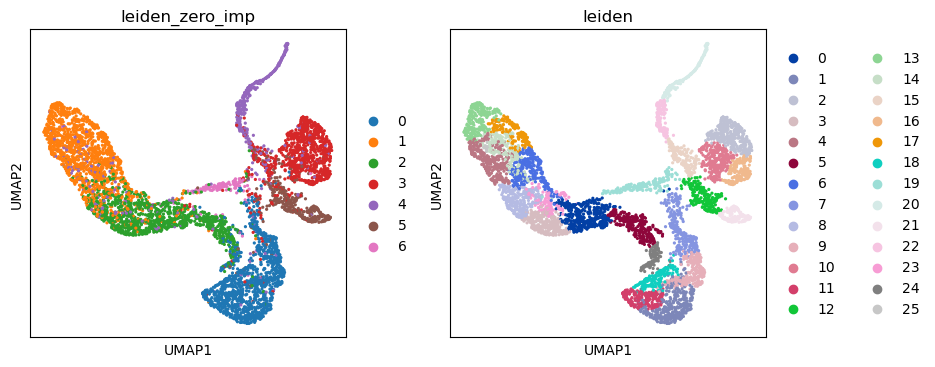

In [82]:
# copy leiden labels
aedata.obs["leiden_zero_imp"] = zdata.obs["leiden"].values

# plot umap with transferred leiden clusters
sc.pl.umap(aedata, color=["leiden_zero_imp", "leiden"])

In [83]:
plot_genes = ['CUX2','ADARB2','MBP'] # 'RORB', 'TLE4','GAD2','LHX6','AQP4','CSF1R' not in the 670 features

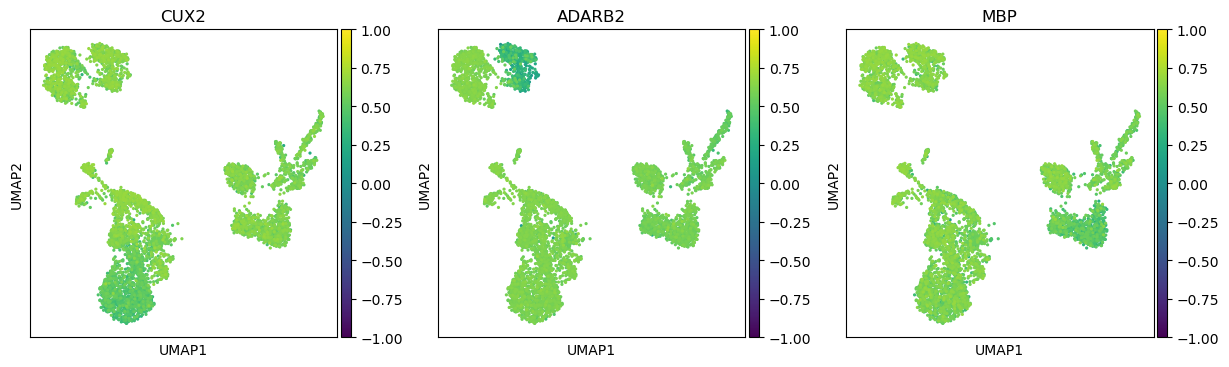

In [84]:
sc.pl.umap(xdata, color=plot_genes, ncols=3, vmin=-1, vmax=1)

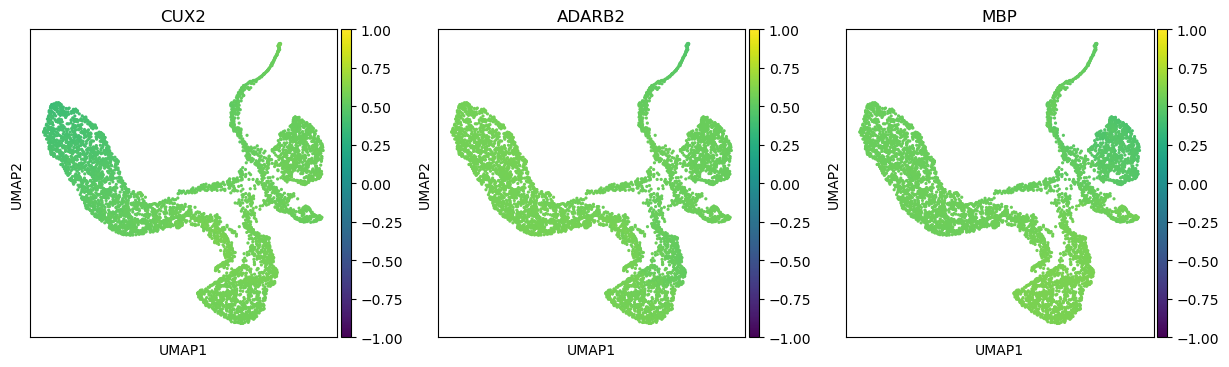

In [85]:
sc.pl.umap(aedata, color=plot_genes, ncols=3, vmin=-1, vmax=1)

In [86]:
# aedata.write_h5ad("mcg_210505_5618x670_autoencoder_zero_imputation_mae.h5ad")
aedata.write_h5ad("mcg_210505_5618x670_autoencoder_mean_imputation_mae.h5ad")
# aedata.write_h5ad("mcg_210505_5618x670_autoencoder_knn_imputation_mae.h5ad")